# Spline interpolation with Green's functions - 2D

##### References

* Lancaster, P., Salkauskas, K., 1980. Curve and Surface Fitting: An Introduction. Academic Press, London, UK pp 280.

* Wessel, Paul. 2009. “A General-Purpose Green’s Function-Based Interpolator.” Computers & Geosciences 35 (6): 1247–54. https://doi.org/10.1016/j.cageo.2008.08.012.

## Synthetic relief model

The cells below compute the synthetic relief model proposed by Lancaster and Salkauskas (1980, p. 150). This model contains two flat regions separated by a linear slope, with a Gaussian peak placed on lower level.

In [1]:
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget
# aka import ipympl

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import numpy as np
from scipy.special import k0 as K0

In [3]:
def synthetic_relief(x, y):
    '''
    Compute the synthetic relief model presented by 
    Lancaster and Salkauskas (1980, p. 150).
    
    Parameters
    ----------
    x, y : arrays
        Coordinates x and y of points on the synthetic model.
    
    Returns
    -------
    z : array
        Coordinates z of the model at the given points (x, y).
    '''
    shapex = x.shape
    shapey = y.shape
    assert shapex == shapey, 'x and y must have the same shape'

    mask1 = ((y - x) >= 0.5)
    mask2 = ((0 <= (y - x)) & ((y - x) < 0.5))
    mask3 = ((x - 1.5)**2 + (y - 0.5)**2 <= 1/16)

    z = np.zeros_like(x)

    z[mask1] = 1
    z[mask2] = 2*(y[mask2] - x[mask2])
    z[mask3] = 0.5*(np.cos(4*np.pi*np.sqrt((x[mask3] - 1.5)**2 + (y[mask3] - 0.5)**2)) + 1)

    return z

In [4]:
# Number of points along x and y
Nx = 100
Ny = 50

# Boundaries of the modelled area
xmin = 0
xmax = 2
ymin = 0
ymax = 1

# Grid of coordinates x and y
x_grid, y_grid = np.meshgrid(np.linspace(xmin, xmax, Nx),
                             np.linspace(ymin, ymax, Ny))

In [5]:
# z coordinates of the relief model
z_grid = synthetic_relief(x_grid, y_grid)

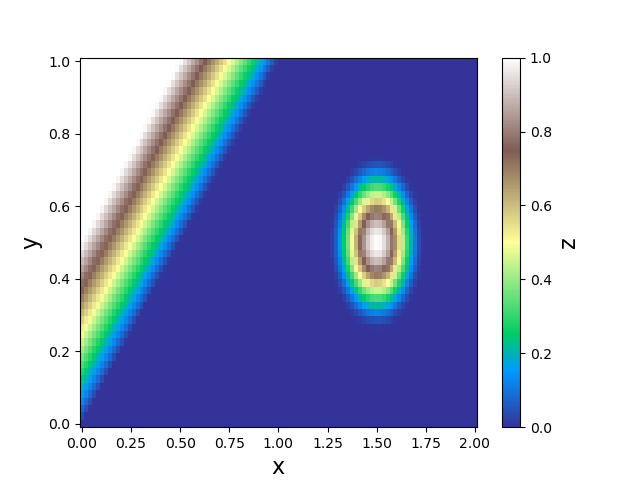

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1)

colormap = ax.pcolormesh(x_grid, y_grid, z_grid, cmap=plt.get_cmap('terrain'))
fig.colorbar(colormap, ax=ax).set_label('z', fontsize=16)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)

plt.show()

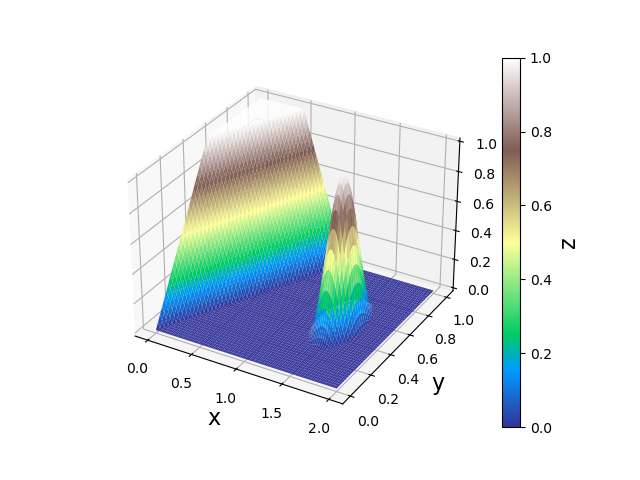

In [7]:
fig = plt.figure()
ax = plt.axes(projection="3d")
colormap3D = ax.plot_surface(x_grid, y_grid, z_grid, rstride=1, cstride=1, cmap=plt.get_cmap('terrain'))
fig.colorbar(colormap3D, ax=ax).set_label('z', fontsize=16)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
plt.show()

## Generate irregularly-spaced points for testing interpolation

In [8]:
# Set the random number generator
rng = np.random.default_rng(8887790345)

# Number of points
N = 150

# x and y coordinates of the irregularly-spaced points
x = xmin + (xmax - xmin)*rng.random(N)
y = ymin + (ymax - ymin)*rng.random(N)

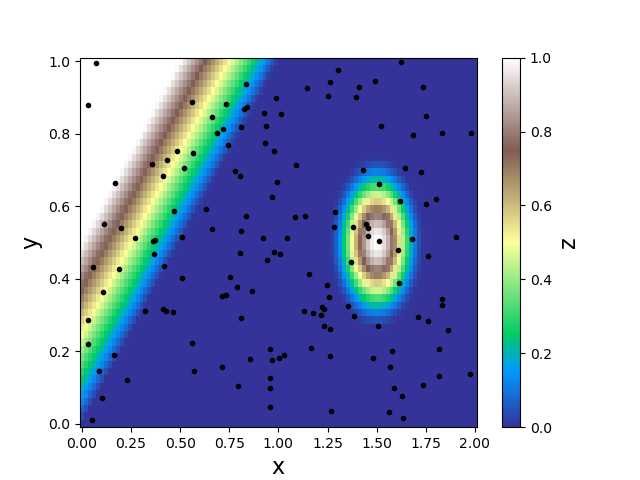

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1)

colormap = ax.pcolormesh(x_grid, y_grid, z_grid, cmap=plt.get_cmap('terrain'))
fig.colorbar(colormap, ax=ax).set_label('z', fontsize=16)
ax.plot(x, y, color='k', marker='o', markersize=3, linewidth=0)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)

plt.show()

## 2D interpolation

Implement the 2D Cartesian Green's functions (Table 1 of notebook `greens_interp_theory`) to interpolate the irregularly-spaced data on the synthetic relief model. For convenience, neglect the trend term $\mathbf{s}(\mathbf{q})$ (equation 5 of notebook `greens_interp_theory`).

In [10]:
def G_2D(p, t=0, p_interp=None):
    '''
    Compute matrix G formed by 2D Cartesian Green's functions.
    
    Parameters
    ----------
    p : array 2D
        Matrix with N rows and 2 columns. The first and second 
        columns contain, respectively, the coordinates x and y
        of the data points.

    t : float
        Positive scalar, in the interval [0, 1[ , controlling the
        tension in spline surface.

    p_interp : array 2D
        Matrix with N rows and 2 columns. The first and second 
        columns contain, respectively, the coordinates x and y
        of the interpolating points.

    Returns
    -------
    G : array 2D
        Matrix of Green's functions.
    '''

    p = np.asarray(p)

    assert p.ndim == 2, 'p must be a matrix'
    assert p.shape[1] == 2, 'p must have two columns'
    assert p.shape[0] > 2, 'p must have more than two rows'
    assert np.isscalar(t), 't must be a scalar'
    assert (t >= 0) and (t < 1), 't must be greater than or equal to zero and lower lower than one' 

    tau = np.sqrt(t/(1-t))

    if p_interp is not None:
        p_interp = np.asarray(p_interp)
        assert p_interp.ndim == 2, 'p_interp must be a matrix'
        assert p_interp.shape[1] == 2, 'p_interp must have two columns'
        assert p_interp.shape[0] > 2, 'p must have more than two rows'
        y = p_interp
    else:
        y = p
    
    G = np.empty((y.shape[0],p.shape[0]))
    if tau == 0:
        for j, (xj, yj) in enumerate(p):
            Dx = y[:,0] - xj
            Dy = y[:,1] - yj
            r = np.sqrt(Dx**2 + Dy**2)
            G[:,j] = r*r*(np.log(r + 1e-15) - 1)
    else:
        for j, (xj, yj) in enumerate(p):
            Dx = y[:,0] - xj
            Dy = y[:,1] - yj
            r = np.sqrt(Dx**2 + Dy**2)
            #G[:,j] = K0(tau*r + 1e-15) + np.log10(tau*r + 1e-15)
            G[:,j] = K0(tau*r + 1e-15) + np.log(tau*r + 1e-15)

    return G

### Estimate 2D spline coefficients

In [11]:
# true relief at interpolated points
y_true = synthetic_relief(x_grid, y_grid)

In [13]:
dobs = synthetic_relief(x, y)

In [14]:
# G matrix without tension
G2D_no_tension = G_2D(p=np.vstack([x, y]).T, t=0, p_interp=None)

In [15]:
# Coefficients without tension
coeffs_no_tension = np.linalg.solve(G2D_no_tension, dobs)

In [16]:
# G matrix with tension
G2D_tension = G_2D(p=np.vstack([x, y]).T, t=0.998, p_interp=None)

In [17]:
# Coefficients with tension
coeffs_tension = np.linalg.solve(G2D_tension, dobs)

### Interpolate 2D data

Use the regular grid (`x_grid` and `y_grid`) as interpolation coordinates.

In [23]:
# Compute interpolated data without tension
G2D_no_tension_interp = G_2D(p=np.vstack([x, y]).T, t=0, 
                             p_interp=np.vstack([np.ravel(x_grid), np.ravel(y_grid)]).T)
y_no_tension_interp = np.dot(G2D_no_tension_interp, coeffs_no_tension)

In [24]:
# Compute interpolated data with tension
G2D_tension_interp = G_2D(p=np.vstack([x, y]).T, t=0.998, 
                          p_interp=np.vstack([np.ravel(x_grid), np.ravel(y_grid)]).T)
y_tension_interp = np.dot(G2D_tension_interp, coeffs_tension)

In [25]:
# reshape the interpolated points for plotting
y_no_tension_interp = np.reshape(y_no_tension_interp, (Ny, Nx))
y_tension_interp = np.reshape(y_tension_interp, (Ny, Nx))

In [26]:
# compute residuals
residuals_no_tension = y_true - y_no_tension_interp
residuals_tension = y_true - y_tension_interp

In [27]:
# set residuals maximum absolute values
res_max_abs_no_tension = np.max(np.abs(residuals_no_tension))
res_max_abs_tension = np.max(np.abs(residuals_tension))
res_max_abs = np.max([res_max_abs_no_tension, res_max_abs_tension])

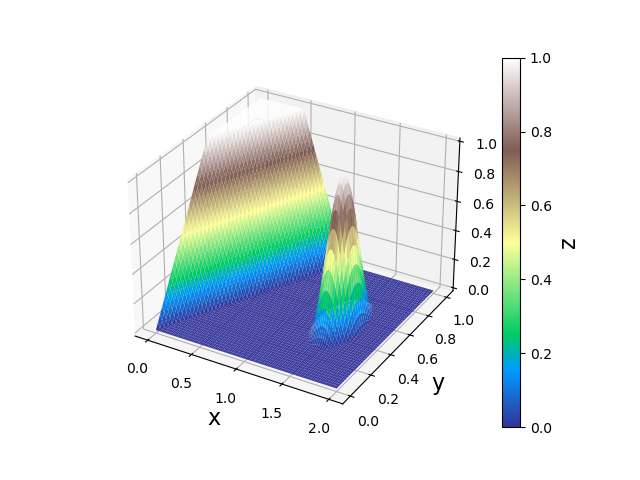

In [28]:
# True model
fig = plt.figure()
ax = plt.axes(projection="3d")
colormap3D = ax.plot_surface(x_grid, y_grid, z_grid, rstride=1, cstride=1, cmap=plt.get_cmap('terrain'))
fig.colorbar(colormap3D, ax=ax).set_label('z', fontsize=16)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
plt.show()

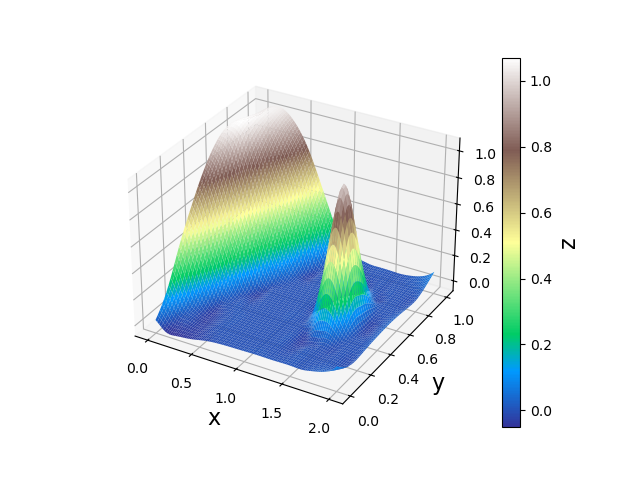

In [29]:
# Interpolated points without tension
fig = plt.figure()
ax = plt.axes(projection="3d")
colormap3D = ax.plot_surface(x_grid, y_grid, y_no_tension_interp, 
                             rstride=1, cstride=1, cmap=plt.get_cmap('terrain'))
fig.colorbar(colormap3D, ax=ax).set_label('z', fontsize=16)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
plt.show()

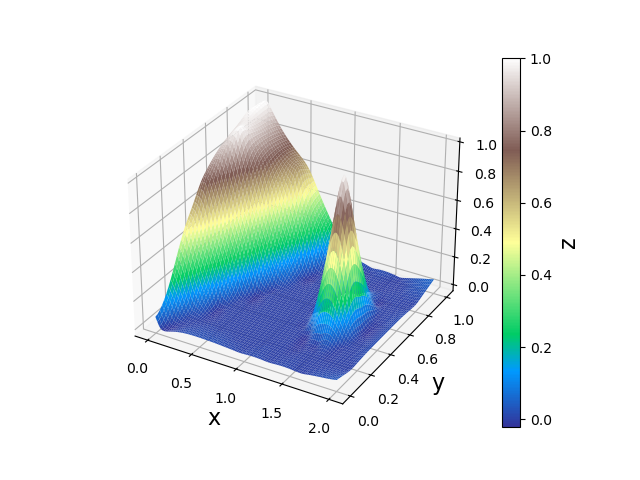

In [30]:
# Interpolated points with tension
fig = plt.figure()
ax = plt.axes(projection="3d")
colormap3D = ax.plot_surface(x_grid, y_grid, y_tension_interp, 
                             rstride=1, cstride=1, cmap=plt.get_cmap('terrain'))
fig.colorbar(colormap3D, ax=ax).set_label('z', fontsize=16)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
plt.show()

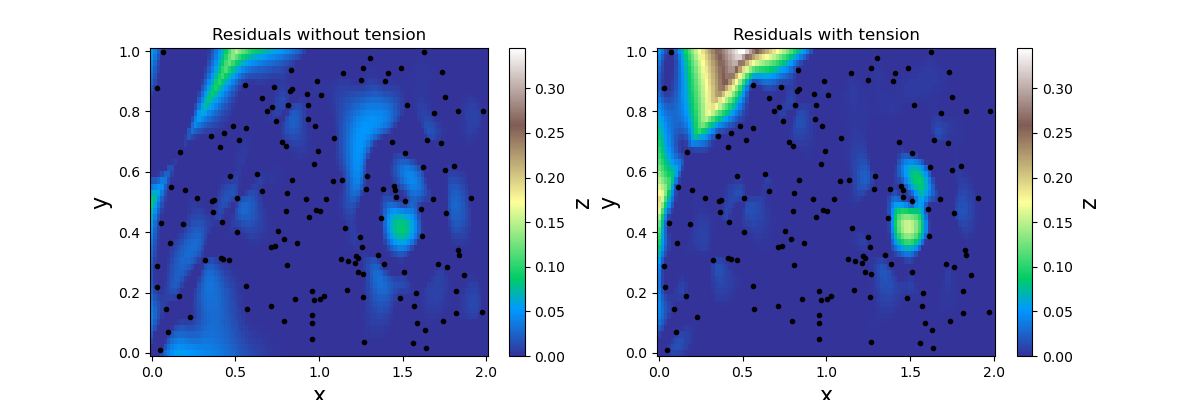

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax[0].set_title('Residuals without tension')
colormap = ax[0].pcolormesh(x_grid, y_grid, residuals_no_tension, cmap=plt.get_cmap('terrain'), vmin=0, vmax=res_max_abs)
fig.colorbar(colormap, ax=ax[0]).set_label('z', fontsize=16)
ax[0].plot(x, y, color='k', marker='o', markersize=3, linewidth=0)
ax[0].set_xlabel('x', fontsize=16)
ax[0].set_ylabel('y', fontsize=16)

ax[1].set_title('Residuals with tension')
colormap = ax[1].pcolormesh(x_grid, y_grid, residuals_tension, cmap=plt.get_cmap('terrain'), vmin=0, vmax=res_max_abs)
fig.colorbar(colormap, ax=ax[1]).set_label('z', fontsize=16)
ax[1].plot(x, y, color='k', marker='o', markersize=3, linewidth=0)
ax[1].set_xlabel('x', fontsize=16)
ax[1].set_ylabel('y', fontsize=16)

plt.show()